In [1]:
# import libraries

import numpy as np
import pandas as pd
from sklearn.datasets import load_files
from glob import glob
from tqdm import tqdm
from os.path import join
from keras.preprocessing import image
from PIL import ImageFile
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, AveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint 
from keras.utils import np_utils
from keras.applications.inception_v3 import InceptionV3
from keras import Model
import time
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
# Load data
train_data_folder = './files/train'
test_data_folder = './files/test'

# function to load the train data
def load_train_data(path):
    data = load_files(path)
    obj_files = np.array(data['filenames'])
    obj_targets = np_utils.to_categorical(np.array(data['target']), 12)    # 3 --> currently: number of categories
    return obj_files, obj_targets

# load train dataset
train_files, train_targets = load_train_data('./files/train')

# load list of objects
obj_names = [item[14:-1] for item in sorted(glob("./files/train/*/"))]
num_obj = len(obj_names)

# print dataset statistics
print('There are %d number of categories.' % len(obj_names))
print('There are %d number of images.' % len(train_files))

There are 12 number of categories.
There are 1444 number of images.


In [3]:
# train_targets
obj_names

['banana',
 'broccoli',
 'cabbage',
 'capsicum',
 'eggplant',
 'grapes',
 'mushroom',
 'onion',
 'orange',
 'peas',
 'potato',
 'tomato']

In [4]:
# Pre-process the Data 
# converting images into 4D Tensors in the form of (no of samples, rows, columns, channels) 
# as required by Keras using Tensorflow as backend
# channels = 3 for RGB images

# Set target of images 
image_width, image_height = 224, 224

def image_to_tensor_format(input_image):
    img = image.load_img(input_image, target_size=(image_width, image_height))
    # convert image to 3D tensor of form (224, 224, 3)
    image_tensor = image.img_to_array(img)
    # converting 3D tensor to 4D tensor as required by keras as (1, 224, 224, 3) and return
    # no of samples = 1 as for a single image
    return np.expand_dims(image_tensor, axis=0)

def train_to_tensor(image_path):
    tensor_list = [image_to_tensor_format(img) for img in tqdm(image_path)]
    return np.vstack(tensor_list)          # Stack arrays in sequence vertically (row wise)

In [14]:
# preprocessing - rescaling images by dividing all pixels by 255
# normalising the values from 0-1
ImageFile.LOAD_TRUNCATED_IMAGES = True     # for error handling while reading images

train_data = train_to_tensor(train_files).astype('float32')/255

100%|██████████| 1444/1444 [00:04<00:00, 336.20it/s]


### Basic CNN Model using Keras

In [15]:
# CNN Model -- basic with only Keras (no pre-trained model)

model = Sequential()

model.add(Conv2D(filters = 16, kernel_size = (5,5), strides = (2,2), padding = 'valid', activation = 'relu', 
          input_shape = (image_width, image_height, 3)))
model.add(Conv2D(filters = 32, kernel_size = (5,5), strides = (4,4), padding = 'valid', activation = 'relu'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=None, padding='valid'))
model.add(Conv2D(filters = 64, kernel_size = (2,2), strides = (2,2), padding = 'valid', activation = 'relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(200, activation='relu'))
model.add(Dense(num_obj, activation='softmax'))


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 110, 110, 16)      1216      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 9, 32)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          8256      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                2412      
Total para

In [16]:
# Compiling the model 
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Training the model

# number of epochs to train the model
# one epoch = one forward pass and one backward pass of all the training examples

epochs = 5

# checkpoints to save model with minimum loss
checkpoints = ModelCheckpoint(filepath='./chkpoints/checkpoints_with_best_loss.hdf5', 
                               verbose=1, save_best_only=True)

#model.load_weights('./chkpoints/checkpoints_with_best_loss.hdf5')

base_history = model.fit(train_data, train_targets, validation_split=0.2, epochs=epochs, batch_size=20, 
          callbacks=[checkpoints], verbose=1)

Train on 1155 samples, validate on 289 samples
Epoch 1/5
1155/1155 [==============================] - 19s 17ms/step - loss: 2.2604 - acc: 0.1818 - val_loss: 1.9933 - val_acc: 0.2422
Epoch 2/5
1155/1155 [==============================] - 18s 16ms/step - loss: 1.8108 - acc: 0.3394 - val_loss: 1.5908 - val_acc: 0.4291
Epoch 3/5
1155/1155 [==============================] - 20s 18ms/step - loss: 1.6022 - acc: 0.4130 - val_loss: 1.5037 - val_acc: 0.4775
Epoch 4/5
1155/1155 [==============================] - 21s 18ms/step - loss: 1.4584 - acc: 0.4589 - val_loss: 1.3939 - val_acc: 0.5121
Epoch 5/5
1155/1155 [==============================] - 19s 17ms/step - loss: 1.3421 - acc: 0.4935 - val_loss: 1.2457 - val_acc: 0.5329


In [18]:
print(base_history.history.keys()) 

['acc', 'loss', 'val_acc', 'val_loss']


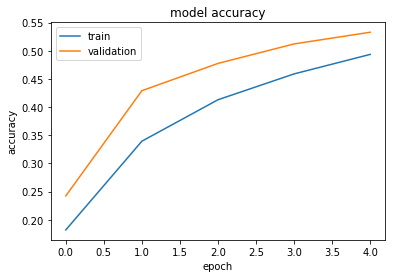

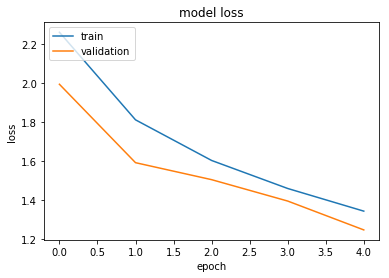

In [19]:
#  "Accuracy"
plt.plot(base_history.history['acc'])
plt.plot(base_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(base_history.history['loss'])
plt.plot(base_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### CNN Model using Transfer Learning

In [20]:
# Finding bottlenecks features for Inception model
# Bottleneck features is getting the remaining of the pre-trained model after removing the final layers
# here include_top=False removes the last layer of Inception

base_model = InceptionV3(weights='imagenet', include_top=False)
# adding our own layers
inception_model = Sequential()
inception_model.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:]))
inception_model.add(Dense(num_obj, activation='softmax')) 
inception_model = Model(inputs=base_model.input, outputs=inception_model(base_model.output))

In [18]:
inception_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_4[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_5 (

In [21]:
# Freezing the inception model layers to be trained
for layer in base_model.layers:
    layer.trainable = False

# Compiling the model 
inception_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [20]:
# Model training
epochs = 5

checkpointes_incptn = ModelCheckpoint(filepath='./chkpoints/checkpoints_with_best_loss_inception.hdf5', 
                               verbose=1, save_best_only=True)

inception_model.load_weights('./chkpoints/checkpoints_with_best_loss_inception.hdf5')

inception_history = inception_model.fit(train_data, train_targets, validation_split=0.2, 
                                        epochs=epochs, batch_size=20, callbacks=[checkpointes_incptn], verbose=1)

Train on 1155 samples, validate on 289 samples
Epoch 1/5
1155/1155 [==============================] - 452s 391ms/step - loss: 1.7273 - acc: 0.4900 - val_loss: 0.7678 - val_acc: 0.7612
Epoch 2/5
1155/1155 [==============================] - 443s 383ms/step - loss: 0.8318 - acc: 0.8182 - val_loss: 0.4405 - val_acc: 0.8720
Epoch 3/5
1155/1155 [==============================] - 465s 403ms/step - loss: 0.5492 - acc: 0.8762 - val_loss: 0.3597 - val_acc: 0.8927
Epoch 4/5
1155/1155 [==============================] - 440s 381ms/step - loss: 0.4286 - acc: 0.8909 - val_loss: 0.3618 - val_acc: 0.8824
Epoch 5/5
1155/1155 [==============================] - 732s 634ms/step - loss: 0.3657 - acc: 0.9004 - val_loss: 0.3650 - val_acc: 0.8685


['acc', 'loss', 'val_acc', 'val_loss']


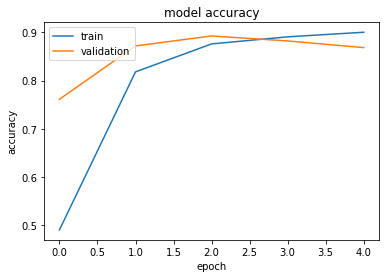

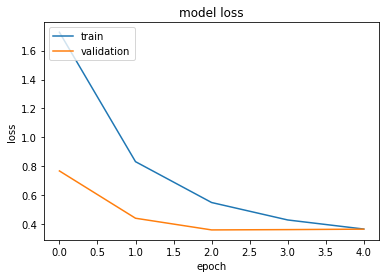

In [21]:
print(inception_history.history.keys())
#  "Accuracy"
plt.plot(inception_history.history['acc'])
plt.plot(inception_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(inception_history.history['loss'])
plt.plot(inception_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [22]:
# Load model weights with best validation loss.
inception_model.load_weights('./chkpoints/checkpoints_with_best_loss_inception.hdf5')

In [62]:
import matplotlib.image as mpimg

top_n = 3

def predict_obj(path):
    
    # load image and convert to 4D tensor
    print('Loading image...')
    image_tensor = image_to_tensor_format(path).astype('float32')/255

    # feed into top_model for obj prediction
    image_prediction = inception_model.predict(image_tensor, batch_size=32, verbose=1)[0]
    obj_predicted = [obj_names[idx] for idx in np.argsort(image_prediction)[::-1][:top_n]]
    confidence_predicted = np.sort(image_prediction)[::-1][:top_n]
    
    return obj_predicted, confidence_predicted


def make_prediction(path):
    obj, confidence = predict_obj(path)
    img = mpimg.imread(path)
    plt.axis('off')
    imgplot = plt.imshow(img)
    print('\nTop 3 predictions:')
    for i, j in zip(obj, confidence):
        print('Predicted obj: {} with a confidence of {:.4f}'.format(i.replace("_", " "), j))

Loading image...
1/1 [==============================] - 0s 353ms/step

Top 3 predictions:
Predicted obj: capsicum with a confidence of 0.9751
Predicted obj: tomato with a confidence of 0.0167
Predicted obj: orange with a confidence of 0.0040


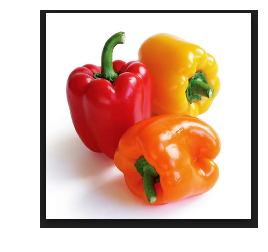

In [63]:
make_prediction('./files/test/capsicum.jpeg')

Loading image...
1/1 [==============================] - 0s 361ms/step

Top 3 predictions:
Predicted obj: grapes with a confidence of 0.6494
Predicted obj: onion with a confidence of 0.2832
Predicted obj: tomato with a confidence of 0.0298


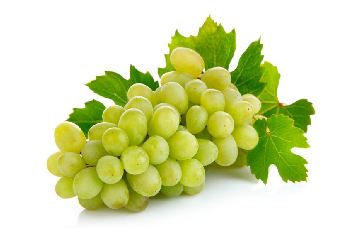

In [58]:
make_prediction('./files/test/grapes1.jpg')

Loading image...
1/1 [==============================] - 0s 338ms/step

Top 3 predictions:
Predicted obj: onion with a confidence of 0.1970
Predicted obj: grapes with a confidence of 0.1825
Predicted obj: eggplant with a confidence of 0.1747


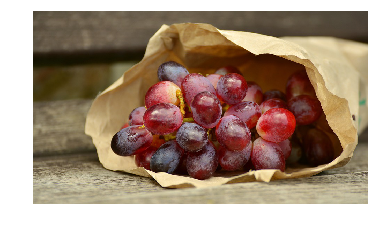

In [59]:
make_prediction('./files/test/grapes.jpg')

Loading image...
1/1 [==============================] - 0s 343ms/step

Top 3 predictions:
Predicted obj: mushroom with a confidence of 0.9591
Predicted obj: potato with a confidence of 0.0103
Predicted obj: grapes with a confidence of 0.0092


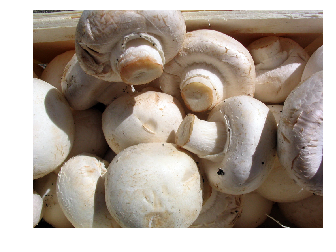

In [60]:
make_prediction('./files/test/mushroom.jpg')

Loading image...
1/1 [==============================] - 0s 342ms/step

Top 3 predictions:
Predicted obj: capsicum with a confidence of 0.9744
Predicted obj: cabbage with a confidence of 0.0123
Predicted obj: tomato with a confidence of 0.0075


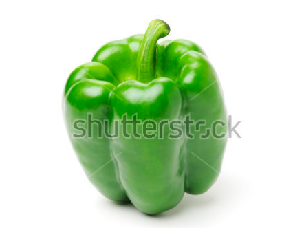

In [61]:
make_prediction('./files/test/capsicum1.png')

Loading image...
1/1 [==============================] - 0s 362ms/step

Top 3 predictions:
Predicted obj: potato with a confidence of 0.8731
Predicted obj: mushroom with a confidence of 0.0430
Predicted obj: tomato with a confidence of 0.0314


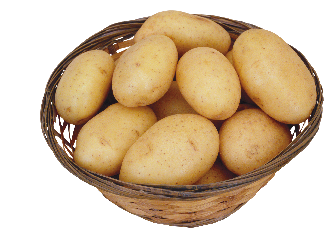

In [64]:
make_prediction('./files/test/potato.png')

Loading image...
1/1 [==============================] - 0s 419ms/step

Top 3 predictions:
Predicted obj: onion with a confidence of 0.9169
Predicted obj: tomato with a confidence of 0.0492
Predicted obj: mushroom with a confidence of 0.0075


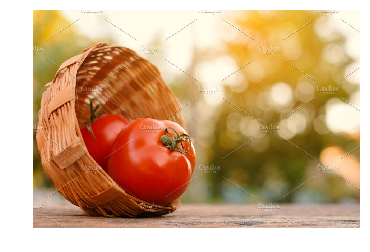

In [65]:
make_prediction('./files/test/tomato.jpg')

Loading image...
1/1 [==============================] - 0s 374ms/step

Top 3 predictions:
Predicted obj: tomato with a confidence of 0.7922
Predicted obj: capsicum with a confidence of 0.1125
Predicted obj: grapes with a confidence of 0.0300


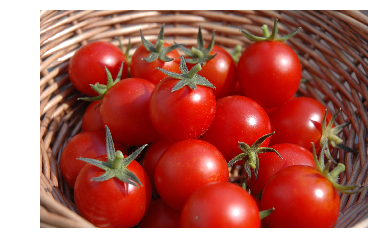

In [66]:
make_prediction('./files/test/tomato1.jpg')

Loading image...
1/1 [==============================] - 0s 394ms/step

Top 3 predictions:
Predicted obj: onion with a confidence of 0.8758
Predicted obj: banana with a confidence of 0.0403
Predicted obj: mushroom with a confidence of 0.0255


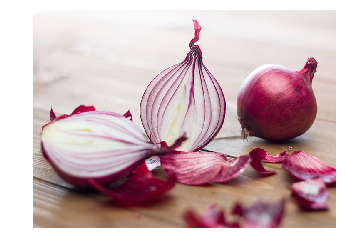

In [68]:
make_prediction('./files/test/onion.jpg')